In [1]:
!pip install -q transformers

In [2]:
!pip install -q texthero

In [3]:
%cd ./drive/MyDrive/review/

/content/drive/MyDrive/review


In [4]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
import torch.nn as nn 
import torch 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import os, time, pickle, json
import texthero as hero
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW
from typing import Dict, List, Any, Tuple, Union 
from sklearn.metrics import f1_score
import warnings
from statistics import mean 
import random 
from sklearn.model_selection import StratifiedKFold

In [5]:
train = pd.read_csv("./raw/train.csv")
test = pd.read_csv("./raw/test.csv")
train.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [6]:
train.isnull().sum() / train.shape[0]

id           0.000000
title        0.000000
abstract     0.161724
judgement    0.000000
dtype: float64

In [7]:
train.judgement.value_counts() / train.shape[0]

0    0.976718
1    0.023282
Name: judgement, dtype: float64

In [6]:
def clern_txt(df, is_train=True):
    df["abstract"] = df.abstract.fillna(" ")
    df["content"] = df["title"] + " " + df["abstract"]
    clean_text = hero.clean(df.content, pipeline=[
        hero.preprocessing.fillna,
        hero.preprocessing.lowercase,
        hero.preprocessing.remove_digits,
        hero.preprocessing.remove_punctuation,
        hero.preprocessing.remove_diacritics,
        hero.preprocessing.remove_stopwords,
        hero.preprocessing.remove_whitespace
    ])
    df["contents"] = clean_text 
    del df.abstract
    if is_train:
        df = df[["contents", "judgement"]]
    else:
        df = df[["contents"]]
    return df 

train = clern_txt(train)
test = clern_txt(test, False)

In [7]:
train.head()

,contents,judgement
0,one year age changes mri brain volumes older a...,0
1,supportive csf biomarker evidence enhance nati...,0
2,occurrence basal ganglia germ cell tumors with...,0
3,new developments diagnosis therapy crohn disea...,0
4,prolonged shedding sars cov elderly liver tran...,0


In [8]:
except_word = [" ", " . ", "the", "a", "of", "and", "in", "to", "with", "for", "was", "were", 
               "is", "that", "this", "as", "we", "i", "I", "there", "they", "you", "", ".", "are", 
               "or", "at", "0", "these", "be", "on", "from", "alt", "has", "many", "ad"]

def show_vocab(content, threshold=5000, label_name: Union["all", "negative", "positive"]="negative"):
    word2index = {}
    add_vocab = []
    for doc in content.to_list():
        for word in doc.split():
            word = word.strip()
            if word not in word2index:
                word2index[word] = 1 
            else:
                word2index[word] += 1 
    vocab2index = {}
    for k, v in word2index.items():
        if k in except_word: continue
        if v >= threshold:
            vocab2index[k] = v
            if label_name == "all":
                add_vocab.append(k)

    wordcloud = WordCloud().generate_from_frequencies(vocab2index)
    del word2index 
    plt.imshow(wordcloud)
    plt.title(f"{label_name}")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    del vocab2index 
    if label_name == "all":
        return add_vocab

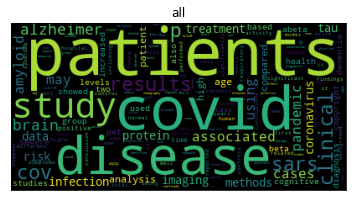

In [9]:
add_vocab = show_vocab(train.contents, 3000, "all")

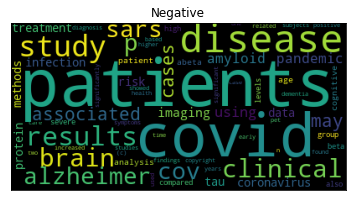

In [12]:
show_vocab(train[train.judgement == 0]["contents"], 5000, "Negative")

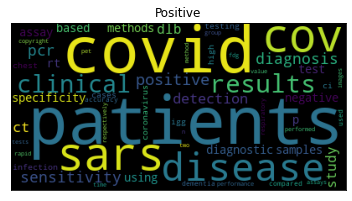

In [13]:
show_vocab(train[train.judgement == 1]["contents"], 200, "Positive")

In [10]:
len(add_vocab)

156

In [11]:
OUTPUT_DIR = "./"
def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_tokenizer_model(add_vocab):
    tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")
    tokenizer.add_tokens(add_vocab)
    model = AutoModelForSequenceClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=1).to(device)
    model.resize_token_embeddings(len(tokenizer))
    print(model.config)
    del add_vocab
    return tokenizer, model

seed = 471
seed_torch(seed)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
warnings.simplefilter("ignore")
tokenizer, model = load_tokenizer_model(add_vocab)


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31095
}



In [12]:
def get_train_data(train):
    '''正と負を均等に分割する'''
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for n, (tr_id, va_id) in enumerate(kf.split(train, train.judgement)):
        train.loc[va_id, "fold"] = int(n)
    train["fold"] = train.fold.astype(np.uint8)
    return train

train = get_train_data(train)
train.head()

,contents,judgement,fold
0,one year age changes mri brain volumes older a...,0,0
1,supportive csf biomarker evidence enhance nati...,0,1
2,occurrence basal ganglia germ cell tumors with...,0,4
3,new developments diagnosis therapy crohn disea...,0,3
4,prolonged shedding sars cov elderly liver tran...,0,1


In [13]:
class BaseDataset(object):
    def __init__(self, df, is_train=True):
        '''
        Parameter
        --------
        df: あらかじめfold分割されたデータセットを渡す
        is_train: 訓練検証またはテスト
        '''
        self.contents = df["contents"].to_list()
        self.is_train = is_train
        if is_train:
            self.labels = df["judgement"].to_list()
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        doc = self.contents[idx]
        encoding = self.tokenizer(doc, padding="max_length", max_length=128,
                                  truncation=True, return_tensors="pt", return_token_type_ids=False)
        encoding = {k: v[0] for k, v in encoding.items()}
        if self.is_train:
            label = torch.tensor(self.labels[idx])
            encoding["labels"] = label
        encoding = {k: v.to(device)  for k, v in encoding.items()}
        return encoding 

    def __len__(self):
        return len(self.contents)


In [14]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.base_model = model
        for n, w in self.base_model.named_parameters():
            if n in ["bert.pooler.dense.weight", "bert.pooler.dense.bias", 
                     "classifier.weight", "classifier.bias"]:
                     w.requires_grad = True 
            else:
                w.requires_grad = False
        self.sigmoid = nn.Sigmoid()
    def forward(self, input_ids, attention_mask):
        out = self.base_model(input_ids=input_ids, attention_mask=attention_mask).logits
        out = self.sigmoid(out)
        return out 



In [17]:
def train_fn(train_dl, net, criterion, optimizer, epoch) -> float:
    start = time.time()
    net.train()
    total_loss = []
    losses = []
    for i, data in enumerate(train_dl):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        output = net(input_ids, attention_mask)
        loss = criterion(output.view(-1), labels.float())

        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        total_loss.append(loss.item())
        optimizer.step()

        if i%100 == 0:
            now = time.time()
            LOGGER.info(
                f"Epoch: {epoch+1} | train | elapsed: {now-start}s Loss: {mean(losses)} "
            )
            losses = []
    torch.cuda.empty_cache()
    del loss 
    return mean(total_loss)

def val_fn(val_dl, net, criterion, epoch) -> Tuple[float, List[float], List[int]]:
    start = time.time()
    net.eval()
    total_loss = []
    losses = []
    prediction, correct = [], []
    for i, data in enumerate(val_dl):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        labels = data["labels"].to(device)

        with torch.no_grad():
            output = net(input_ids, attention_mask)
        loss = criterion(output.view(-1), labels.float())

        losses.append(loss.item())
        total_loss.append(loss.item())

        for p in output.detach().cpu().numpy().tolist():
            prediction.append(p[0]) # 0-1
        for c in labels.detach().cpu().numpy().tolist():
            correct.append(int(c)) # 0 or 1 

        if i%100 == 0:
            now = time.time()
            LOGGER.info(
                f"Epoch: {epoch+1} | val | elapsed: {now-start}s Loss: {mean(losses)}"
            )
            losses = []
    torch.cuda.empty_cache()
    del loss 
    return mean(total_loss), prediction, correct 
        

In [18]:
def train_loop(train, fold) -> Tuple[List[float], List[int]]:
    LOGGER.info(f"---------FOLD:{fold}training-----------")
    train_ds = BaseDataset(train[train.fold != fold], True)
    val_ds = BaseDataset(train[train.fold == fold], True)
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=True, drop_last=True)

    net = BaseModel()
    net.to(device)

    optimizer = AdamW(net.parameters(), lr=2e-5)
    criterion = nn.BCELoss() # クラス分類ではなく２乗平均誤差関数
    best_loss = np.inf
    best_net = None 
    best_predict, best_correct, best_net = None, None, None 

    for e in range(3):
        train_loss = train_fn(train_dl, net, criterion, optimizer, e)
        val_loss, predict, correct = val_fn(val_dl, net, criterion, e)

        if val_loss < best_loss:
            best_loss = val_loss 
            best_predict = predict 
            best_correct = correct 
            best_net = net 
        
    print(f"Best Validation Loss: {best_loss:.5f}")
    os.makedirs("weights", exist_ok=True)
    torch.save(best_net.state_dict(), f"./weights/net{fold}.pth")
    return best_predict, best_correct


def main(train: pd.DataFrame) -> Dict[str, float]:
    '''学習を実行する'''
    prediction, correct = [], []
    for fold in range(5):
        pred, corr = train_loop(train, fold)
        for p in pred: # float
            prediction.append(p)
        for c in corr: # int 
            correct.append(c)

    prediction = np.array(prediction)
    result = {}
    
    for threshold in np.arange(0.01, 0.2, 0.012):
        pred = np.where(prediction > threshold, 1, 0).astype(np.uint8).tolist()
        f1 = f1_score(pred, correct)
        result[str(threshold)] = f1 
    return result 

main(train)



---------FOLD:0training-----------


Epoch: 1 | train | elapsed: 0.09302520751953125s Loss: 0.016227729618549347 
Epoch: 1 | train | elapsed: 7.2101733684539795s Loss: 0.07107474294956774 
Epoch: 1 | train | elapsed: 14.319933891296387s Loss: 0.07548833538545295 
Epoch: 1 | train | elapsed: 21.3948016166687s Loss: 0.048747313204221425 
Epoch: 1 | train | elapsed: 28.425086975097656s Loss: 0.12260187944862992 
Epoch: 1 | train | elapsed: 35.46376419067383s Loss: 0.07284038501791656 
Epoch: 1 | train | elapsed: 42.476855993270874s Loss: 0.06660547334700823 
Epoch: 1 | train | elapsed: 49.472684144973755s Loss: 0.08727993646636606 
Epoch: 1 | train | elapsed: 56.44994854927063s Loss: 0.05208394815679639 
Epoch: 1 | train | elapsed: 63.446446895599365s Loss: 0.06786930554080754 
Epoch: 1 | train | elapsed: 70.44606566429138s Loss: 0.0836101012583822 
Epoch: 1 | train | elapsed: 77.44518637657166s Loss: 0.07645631086546928 
Epoch: 1 | train | elapsed: 84.41976070404053s Loss: 0.0702332456689328 
Epoch: 1 | train | elapsed: 91.

---------FOLD:1training-----------


Epoch: 1 | train | elapsed: 0.07119369506835938s Loss: 0.005876726470887661 
Epoch: 1 | train | elapsed: 7.033444166183472s Loss: 0.026710378966818098 
Epoch: 1 | train | elapsed: 14.065698146820068s Loss: 0.07645691710757091 
Epoch: 1 | train | elapsed: 21.110509395599365s Loss: 0.051186733212089164 
Epoch: 1 | train | elapsed: 28.10150146484375s Loss: 0.05015188966179267 
Epoch: 1 | train | elapsed: 35.07444620132446s Loss: 0.07939776037936098 
Epoch: 1 | train | elapsed: 42.042003870010376s Loss: 0.09020428654737771 
Epoch: 1 | train | elapsed: 49.00052571296692s Loss: 0.031137755459640176 
Epoch: 1 | train | elapsed: 55.98095488548279s Loss: 0.0417713130248012 
Epoch: 1 | train | elapsed: 62.989633321762085s Loss: 0.07676018239697441 
Epoch: 1 | train | elapsed: 69.96764588356018s Loss: 0.05085969351464883 
Epoch: 1 | train | elapsed: 76.95953273773193s Loss: 0.07849976325640455 
Epoch: 1 | train | elapsed: 83.93752360343933s Loss: 0.08219202142907306 
Epoch: 1 | train | elapsed: 9

---------FOLD:2training-----------


Epoch: 1 | train | elapsed: 0.07310104370117188s Loss: 0.062302812933921814 
Epoch: 1 | train | elapsed: 7.059460163116455s Loss: 0.07547917385702022 
Epoch: 1 | train | elapsed: 14.164560317993164s Loss: 0.06520093509578145 
Epoch: 1 | train | elapsed: 21.212193250656128s Loss: 0.042688801496988164 
Epoch: 1 | train | elapsed: 28.207178592681885s Loss: 0.06073723119567148 
Epoch: 1 | train | elapsed: 35.21656012535095s Loss: 0.045633936437079685 
Epoch: 1 | train | elapsed: 42.20145225524902s Loss: 0.08184265764779411 
Epoch: 1 | train | elapsed: 49.18989419937134s Loss: 0.03757194269011961 
Epoch: 1 | train | elapsed: 56.16315293312073s Loss: 0.09154003526782617 
Epoch: 1 | train | elapsed: 63.170978307724s Loss: 0.05424931532004848 
Epoch: 1 | train | elapsed: 70.2029914855957s Loss: 0.08733805265976116 
Epoch: 1 | train | elapsed: 77.2296884059906s Loss: 0.06394654310570332 
Epoch: 1 | train | elapsed: 84.2138774394989s Loss: 0.045238007742154876 
Epoch: 1 | train | elapsed: 91.203

---------FOLD:3training-----------


Epoch: 1 | train | elapsed: 0.07398033142089844s Loss: 0.010381674394011497 
Epoch: 1 | train | elapsed: 7.057513236999512s Loss: 0.0592332422133768 
Epoch: 1 | train | elapsed: 14.175567865371704s Loss: 0.06316716502798954 
Epoch: 1 | train | elapsed: 21.248339414596558s Loss: 0.05984968260978349 
Epoch: 1 | train | elapsed: 28.226024627685547s Loss: 0.09409161870600656 
Epoch: 1 | train | elapsed: 35.2438588142395s Loss: 0.06546153432311258 
Epoch: 1 | train | elapsed: 42.26810073852539s Loss: 0.053748389042448254 
Epoch: 1 | train | elapsed: 49.26698970794678s Loss: 0.0695043916470604 
Epoch: 1 | train | elapsed: 56.27867817878723s Loss: 0.047485861050081436 
Epoch: 1 | train | elapsed: 63.27070927619934s Loss: 0.05975031439797021 
Epoch: 1 | train | elapsed: 70.27887415885925s Loss: 0.049449083363288085 
Epoch: 1 | train | elapsed: 77.26864314079285s Loss: 0.07562705311749596 
Epoch: 1 | train | elapsed: 84.25843048095703s Loss: 0.06352167768171058 
Epoch: 1 | train | elapsed: 91.2

---------FOLD:4training-----------


Epoch: 1 | train | elapsed: 0.07720136642456055s Loss: 0.04590331390500069 
Epoch: 1 | train | elapsed: 7.078138828277588s Loss: 0.060404993839911186 
Epoch: 1 | train | elapsed: 14.228434085845947s Loss: 0.08782575492368778 
Epoch: 1 | train | elapsed: 21.23085904121399s Loss: 0.10830556678760331 
Epoch: 1 | train | elapsed: 28.22584104537964s Loss: 0.02203708207933232 
Epoch: 1 | train | elapsed: 35.2039110660553s Loss: 0.08748238020954886 
Epoch: 1 | train | elapsed: 42.16992425918579s Loss: 0.06748101144272368 
Epoch: 1 | train | elapsed: 49.17634701728821s Loss: 0.05925101180444472 
Epoch: 1 | train | elapsed: 56.169941663742065s Loss: 0.045221898508025334 
Epoch: 1 | train | elapsed: 63.162835121154785s Loss: 0.05804699162370525 
Epoch: 1 | train | elapsed: 70.14265465736389s Loss: 0.04230552184249973 
Epoch: 1 | train | elapsed: 77.11657929420471s Loss: 0.06327356300782412 
Epoch: 1 | train | elapsed: 84.10096478462219s Loss: 0.08043557100580073 
Epoch: 1 | train | elapsed: 91.0

{'0.01': 0.1551949751373986,
 '0.022': 0.23600605143721634,
 '0.033999999999999996': 0.2997685185185185,
 '0.046': 0.3374083129584352,
 '0.057999999999999996': 0.37209302325581395,
 '0.06999999999999999': 0.4003647970816234,
 '0.08199999999999999': 0.4143145161290323,
 '0.09399999999999999': 0.4267690619857377,
 '0.10599999999999998': 0.4494649227110582,
 '0.11799999999999998': 0.4601880877742947,
 '0.12999999999999998': 0.4635761589403973,
 '0.142': 0.46132404181184666,
 '0.154': 0.46965317919075145,
 '0.16599999999999998': 0.4747550866616428,
 '0.178': 0.4755244755244756,
 '0.18999999999999997': 0.4730490748189863}

In [ ]:
def find_thre():
    with torch.no_grad():
        prediction = []
        correct = []
        for fold in range(5):
            net = BaseModel()
            net.load_state_dict(torch.load(f"./weights/net{str(fold)}.pth", map_location={"cuda:0": "cpu"}))
            net.eval()
            net.to(device)
            val_ds = BaseDataset(train[train.fold == fold], True)
            val_dl = torch.utils.data.DataLoader(val_ds, batch_size=4, shuffle=False)

            for data in val_dl:
                input_ids = data["input_ids"].to(device)
                attention_mask = data["attention_mask"].to(device)
                labels = data["labels"].to(device)

                output = net(input_ids, attention_mask)
                output = output.detach().cpu().numpy().tolist()
                corr = labels.detach().cpu().numpy().tolist()
                for p in output:
                    prediction.append(p[0])
                for c in corr:
                    correct.append(c)
    torch.cuda.empty_cache()
    return prediction, correct 

predict, correct = find_thre()


In [144]:
def test_fn(test, net, fold) -> List[float]:
    '''推論を実行して確率を返す'''
    predict = []
    net.load_state_dict(torch.load(f"./weight/net{fold}.pth", map_location={"cuda:0": "cpu"}))
    net.eval()
    net.to(device)

    for i, data in enumerate(test):
        input_ids = test["input_ids"].to(device)
        attention_mask = test["attention_mask"].to(device)

        with torch.no_grad():
            output = net(input_ids, attention_mask)
            output = output[0].detach().cpu().numpy().tolist()
            for o in output:
                predict.append(o)
    print(f"complete {fold} counts")
    del net 
    del loss 
    return predict

def inference(test) -> np.ndarray:
    '''Foldに分割されたそれぞれのモデル予測の平均を使う'''
    test_ds = BaseDataset(test, False)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=False)
    net = BaseModel()
    prediction = []
    for fold in range(5):
        pred = test_fn(test_dl, net, fold)
        prediction.append(pred) # (5, test_size)
    prediction = np.array(prediction)
    prediction = np.mean(prediction, axis=0) # (test_size, )
    return prediction 

def submittion(test, threshold):
    predict = inference(test)
    predict = np.where(predict > threshold, 1, 0).astype(np.uint8).tolist()
    sub_file = pd.read_csv("./raw/sample_submit.csv")
    sub_file.columns = ["id", "sample"]
    sub_file = subfile[["id"]]
    sub_file["predict"] = predict 
    sub_file.to_csv("./raw/submit0914scibert.csv", index=False, header=False)



NameError: ignored